In [1]:
import os
os.chdir("../")

In [3]:
TEXT_COLOR = '#313131'
LINE_COLORS = ['#00A082', '#F2CC38', '#9B59B6', '#3498DB', '#F39C12']

sns.set(
    style='darkgrid', 
    rc={'figure.figsize':(6,4),
        'figure.dpi': 150,
        'figure.facecolor': 'w', 
        'legend.facecolor': 'w',
        'text.color': TEXT_COLOR,
        'font.family': 'Microsoft Sans Serif', # 'Open Sans',
        'axes.labelcolor': TEXT_COLOR,
        'xtick.color': TEXT_COLOR,
        'ytick.color': TEXT_COLOR}
)

sns.set_palette(sns.color_palette(LINE_COLORS))

# 1. Load the data

In [4]:
data = pd.read_csv('data/house-prices-dataset/train.csv')

In [5]:
# Remove the outlier
data = data.drop(index=1298, axis=0)

In [6]:
# Selecting top-predictor columns IMO
cols = [
    'OverallQual', 
    'GrLivArea',
    'ExterQual',
    'GarageCars',
    'YearBuilt',
    'YearRemodAdd',
    'TotRmsAbvGrd',
    'Foundation',
    'Fireplaces',
    'FireplaceQu',
    'HeatingQC',
    'SalePrice'
]

In [7]:
data = data[cols]

In [8]:
def col_to_dummies(df, col):
    return pd.concat(
        [data, pd.get_dummies(data[col], prefix=col, drop_first=True)], 
        axis=1
    ).drop(col, axis=1)

In [9]:
data['FireplaceQu'] = data['FireplaceQu'].map({
    np.nan: 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5
})

In [10]:
data['HeatingQC'] = data['HeatingQC'].map({
    'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4
})

In [11]:
data['ExterQual'] = data['ExterQual'].map({
    'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4
})

In [12]:
data = col_to_dummies(data, 'Foundation')

In [13]:
x_cols = data.columns.drop("SalePrice").tolist()

In [19]:
X = data[x_cols].copy()

In [20]:
y = data["SalePrice"].copy()

# 2. Apply k-means and PCA in cross-validation

In [16]:
from lib.clustering.k_means import apply_k_means
from lib.preprocessing.pca import apply_pca
from lib.preprocessing.scale import standard_scale
from lib.evaluation.cross_validate import perform_cross_validation
from lib.evaluation.regression import evaluate_regression
from sklearn.ensemble import RandomForestRegressor

In [27]:
def preprocess(X_train, X_valid, y_train, y_valid, kmeans=True, pca=True, target_log=True):
    """Ensures preprocessing without data leakage."""
    ncols = X_train.shape[1]
    
    X_train, X_valid, y_train, y_valid = X_train.values, X_valid.values, y_train.values, y_valid.values
    
    X_train, X_valid = standard_scale(X_train, X_valid)
    
    if pca is True:
        X_train, X_valid = apply_pca(X_train, X_valid, ncols=ncols)
        
    if kmeans is True: 
        X_train, X_valid = apply_k_means(X_train, X_valid, ncols=ncols)
    
    if target_log:
        y_train = np.log(y_train)
    
    return X_train, y_train, X_valid, y_valid

In [44]:
cv_options = [
    {"kmeans": False, "pca": False},
    {"kmeans": True, "pca": False},
    {"kmeans": False, "pca": True},
    {"kmeans": True, "pca": True},
]

Apply to a NON-linear model

In [33]:
model = RandomForestRegressor(n_estimators=500, max_features=0.5, random_state=42)

In [38]:
results = pd.DataFrame()

for kwargs in cv_options:
    print(kwargs)
    metrics = perform_cross_validation(
        X, 
        y, 
        model, 
        preprocess_func=preprocess, 
        eval_func=evaluate_regression, 
        cv_folds=10,
        **kwargs,
    )
    result = pd.DataFrame(data=metrics, index=[str(kwargs)])
    results = pd.concat((results, result), axis=0)

{'kmeans': False, 'pca': False}
{'kmeans': True, 'pca': False}
{'kmeans': False, 'pca': True}
{'kmeans': True, 'pca': True}


Text(0.5, 1.0, 'Metric performance')

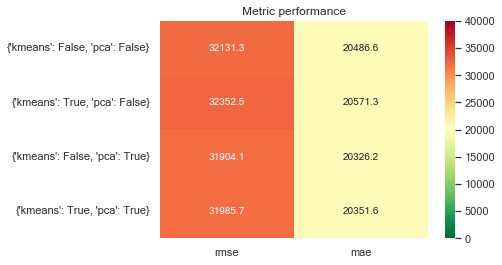

In [39]:
sns.heatmap(data=results, vmin=0, vmax=40000, annot=True, fmt='g', cmap='RdYlGn_r')
plt.title("Metric performance")

Apply to a linear model

In [40]:
from sklearn.linear_model import LinearRegression

In [41]:
model = LinearRegression()

In [42]:
results = pd.DataFrame()

for kwargs in cv_options:
    print(kwargs)
    metrics = perform_cross_validation(
        X, 
        y, 
        model, 
        preprocess_func=preprocess, 
        eval_func=evaluate_regression, 
        cv_folds=10,
        **kwargs,
    )
    result = pd.DataFrame(data=metrics, index=[str(kwargs)])
    results = pd.concat((results, result), axis=0)

{'kmeans': False, 'pca': False}
{'kmeans': True, 'pca': False}
{'kmeans': False, 'pca': True}


/Users/pavlo.seimskyi/Desktop/github-repos/ds-mentorship/lib/evaluation/cross_validate.py:22: RuntimeWarning: overflow encountered in exp
  y_pred = np.exp(y_pred_log)


ValueError: Input contains infinity or a value too large for dtype('float64').

Text(0.5, 1.0, 'Metric performance')

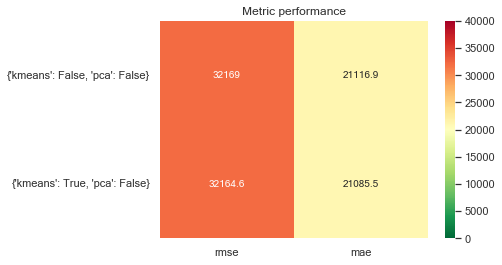

In [43]:
sns.heatmap(data=results, vmin=0, vmax=40000, annot=True, fmt='g', cmap='RdYlGn_r')
plt.title("Metric performance")

# Conclusion
Linear regression explodes when using PCA as features!

Using k-means as feature improves performance minimally, at least for this specific data set.

---

# 3. Explore how k-means works

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

### 3.1. Apply to raw data

In [45]:
km = KMeans(n_clusters=3, random_state=42)

In [46]:
km.fit(data[x_cols])

KMeans(n_clusters=3, random_state=42)

In [47]:
data['cluster'] = km.labels_

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

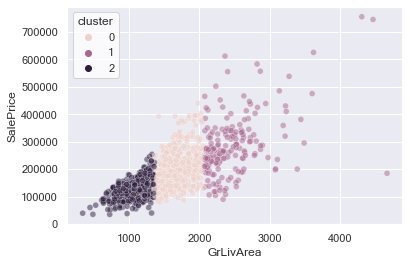

In [48]:
sns.scatterplot(data=data, x='GrLivArea', y='SalePrice', hue='cluster', alpha=0.5)

Seems like GrLivArea was the most decisive factor to assign clusters because it is of large numbers.

### 3.2. Apply to scaled data

In [49]:
from sklearn.preprocessing import StandardScaler

In [50]:
scaler = StandardScaler()

In [51]:
scaled_data = data.drop("cluster", axis=1).copy()

In [52]:
scaled_data[x_cols] = scaler.fit_transform(scaled_data[x_cols])

In [53]:
km = KMeans(n_clusters=3, random_state=42)

In [54]:
km.fit(scaled_data[x_cols])

KMeans(n_clusters=3, random_state=42)

In [55]:
scaled_data['cluster'] = km.labels_

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

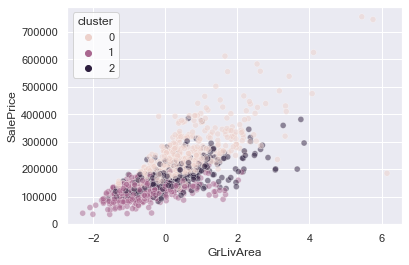

In [56]:
sns.scatterplot(data=scaled_data, x='GrLivArea', y='SalePrice', hue='cluster', alpha=0.5)

### Plot principal components of PCA vs clusters

In [57]:
from sklearn.decomposition import PCA

In [58]:
pca = PCA()

In [59]:
pcomps = pca.fit_transform(scaled_data[x_cols])

In [60]:
pc_cols = [f"PC{n+1}" for n in range(pcomps.shape[1])]

In [61]:
scaled_data[pc_cols] = pcomps

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

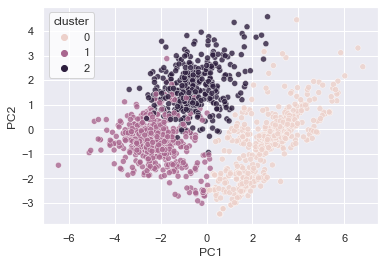

In [62]:
sns.scatterplot(data=scaled_data, x='PC1', y='PC2', hue='cluster', alpha=0.8)

<AxesSubplot:xlabel='PC1', ylabel='SalePrice'>

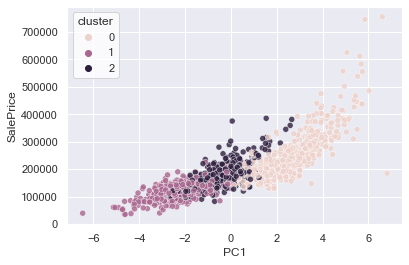

In [63]:
sns.scatterplot(data=scaled_data, x='PC1', y='SalePrice', hue='cluster', alpha=0.8)

### Apply k-means on principal components

In [64]:
km = KMeans(n_clusters=3, random_state=42)

In [65]:
km.fit(scaled_data[pc_cols])

KMeans(n_clusters=3, random_state=42)

In [66]:
scaled_data['pca_cluster'] = km.labels_

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

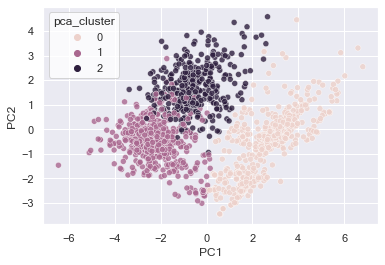

In [67]:
sns.scatterplot(data=scaled_data, x='PC1', y='PC2', hue='pca_cluster', alpha=0.8)

If we apply clustering with all principal compotents, we get the same resulting clustering labels.

---